# NYS Car Crash and Vehicle Registration Analysis


## 1. Introduction

Motor vehicle crashes are a persistent public safety concern in the United States. In 2019 alone, **36,355 people were killed in traffic crashes across the country**, underscoring the widespread and severe impact of road incidents.

This project narrows the focus to **New York State (NYS)**, aiming to understand regional and temporal patterns in crash occurrences. Using open data provided by the New York State government, we conduct an exploratory analysis of motor vehicle crashes from 2019, incorporating additional vehicle registration data to contextualize exposure levels.

Our analysis addresses the following key questions:
- How are crashes distributed across different **days of the week**?
- Which **regions** in NYS experience the highest crash volumes?
- Are there significant **seasonal or weather-related trends** in crash frequency?
- Can smooth modeling (e.g., GAM) reveal hidden patterns in crash fluctuations?

By answering these questions, we seek to uncover interpretable insights into crash dynamics across NYS and lay the groundwork for future predictive or policy-driven work.



## 2. Data Preparation

### 2.1 Vehicle Registration Data

#### Vehicle Registration Distribution by Region

To understand regional differences in vehicle use and population density across New York State, we analyzed the 2023 vehicle registration dataset published by NYS DMV. The dataset includes all active motor vehicle registrations, which we filtered to retain only in-state records (excluding snowmobiles, boats, and out-of-state vehicles).

We mapped each county to one of ten standard NYS economic regions, then visualized the total number of registrations by region using a bar chart. This provides a first glance at how transportation demand varies geographically across the state.

In [ ]:
# Load libraries
library(dplyr)
library(ggplot2)
library(mgcv)

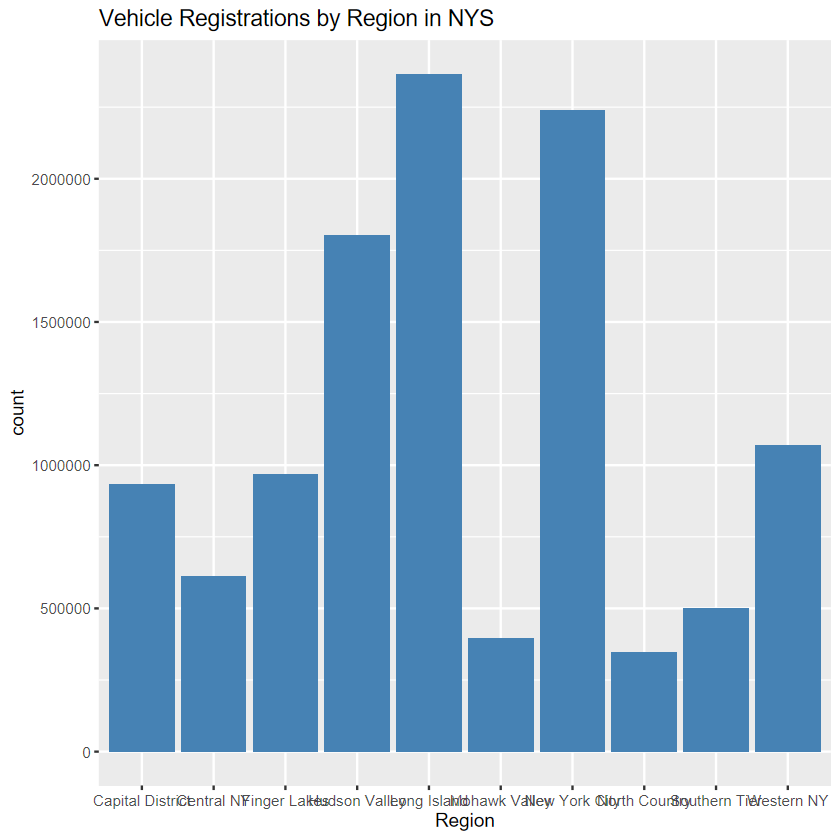

In [ ]:
# ========== 1. Load and Prepare Registration Data ==========
Motor <- read.csv("C:/Users/26759/Documents/Materials/MATH 540/NY Traffic Tickets/Vehicle__Snowmobile__and_Boat_Registrations_20231026.csv", header = TRUE)

# Filter NY State vehicle registrations
Motor1 <- Motor %>%
  filter(Record.Type == "VEH", County != "OUT-OF-STATE") %>%
  select(Record.Type, County)

# Function to map counties into regions
map_region <- function(county) {
  case_when(
    county %in% c("NIAGARA", "ERIE", "CHAUTAUQUA", "CATTARAUGUS", "ALLEGANY") ~ "Western NY",
    county %in% c("ORLEANS", "GENESEE", "WYOMING", "MONROE", "LIVINGSTON", "WAYNE", "ONTARIO", "YATES", "SENECA") ~ "Finger Lakes",
    county %in% c("STEUBEN", "SCHUYLER", "CHEMUNG", "TOMPKINS", "TIOGA", "CHENANGO", "BROOME", "DELAWARE") ~ "Southern Tier",
    county %in% c("CORTLAND", "CAYUGA", "ONONDAGA", "OSWEGO", "MADISON") ~ "Central NY",
    county %in% c("ST LAWRENCE", "LEWIS", "JEFFERSON", "HAMILTON", "ESSEX", "CLINTON", "FRANKLIN") ~ "North Country",
    county %in% c("ONEIDA", "HERKIMER", "FULTON", "MONTGOMERY", "OTSEGO", "SCHOHARIE") ~ "Mohawk Valley",
    county %in% c("ALBANY", "COLUMBIA", "GREENE", "WARREN", "WASHINGTON", "SARATOGA", "SCHENECTADY", "RENSSELAER") ~ "Capital District",
    county %in% c("SULLIVAN", "ULSTER", "DUTCHESS", "ORANGE", "PUTNAM", "ROCKLAND", "WESTCHESTER") ~ "Hudson Valley",
    county %in% c("NEW YORK", "MANHATTAN", "BRONX", "QUEENS", "BROOKLYN", "KINGS", "STATEN ISLAND", "RICHMOND") ~ "New York City",
    county %in% c("NASSAU", "SUFFOLK") ~ "Long Island",
    TRUE ~ NA_character_
  )
}

# Apply mapping
Motor1$Region <- map_region(Motor1$County)

# Plot registration counts by region
ggplot(Motor1, aes(x = Region)) +
  geom_bar(stat = "count", fill = "steelblue") +
  labs(title = "Vehicle Registrations by Region in NYS")

#### Observations

From the bar chart above, it's clear that New York City and Long Island hold the highest number of registered vehicles, reflecting their large populations and high traffic density. Hudson Valley also shows elevated registration numbers, likely due to its commuter proximity to NYC.

In contrast, less urbanized regions such as the North Country and Mohawk Valley have significantly fewer vehicle registrations, which aligns with their lower population density and rural character.

This regional registration breakdown serves as a useful baseline for interpreting traffic volume, crash frequency, and infrastructure stress in subsequent analysis steps.


### 2.2 Crash Data
#### Crash Distribution Overview

To understand motor vehicle crash patterns in New York State for the year 2019, we analyzed statewide crash records by temporal and spatial dimensions. Specifically, we examined:

- Weekly trends by aggregating crashes by the day of the week
- Regional differences by mapping county-level data into 10 economic regions
- Daily crash frequency across the calendar year to identify broader seasonal or cyclical patterns

The goal was to uncover meaningful trends in crash occurrences that may relate to commuting behavior, population distribution, or external factors such as weather or holidays.


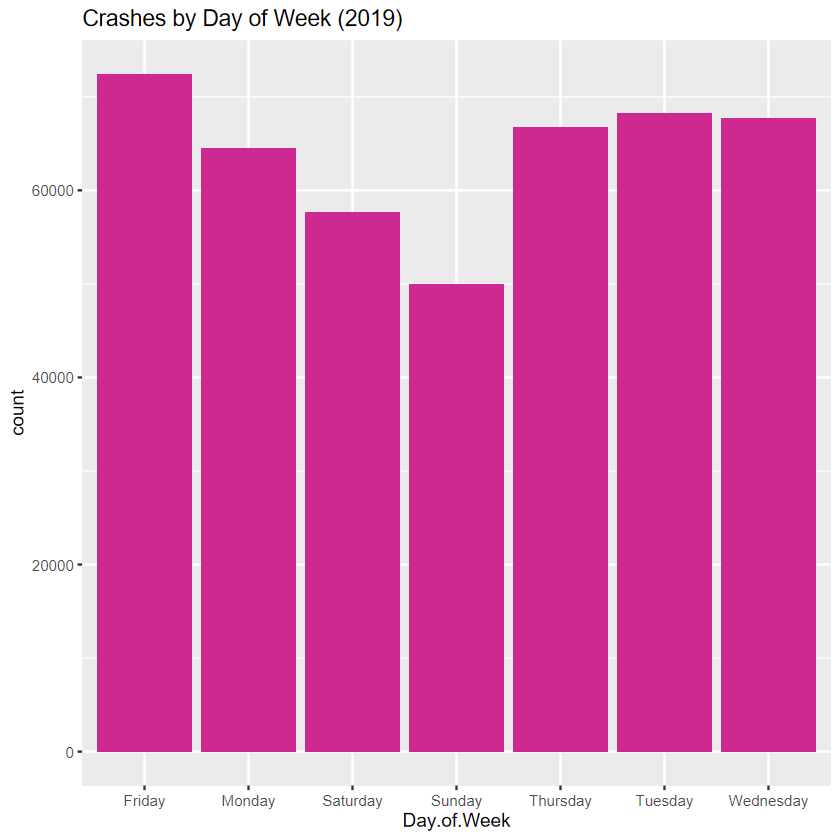

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


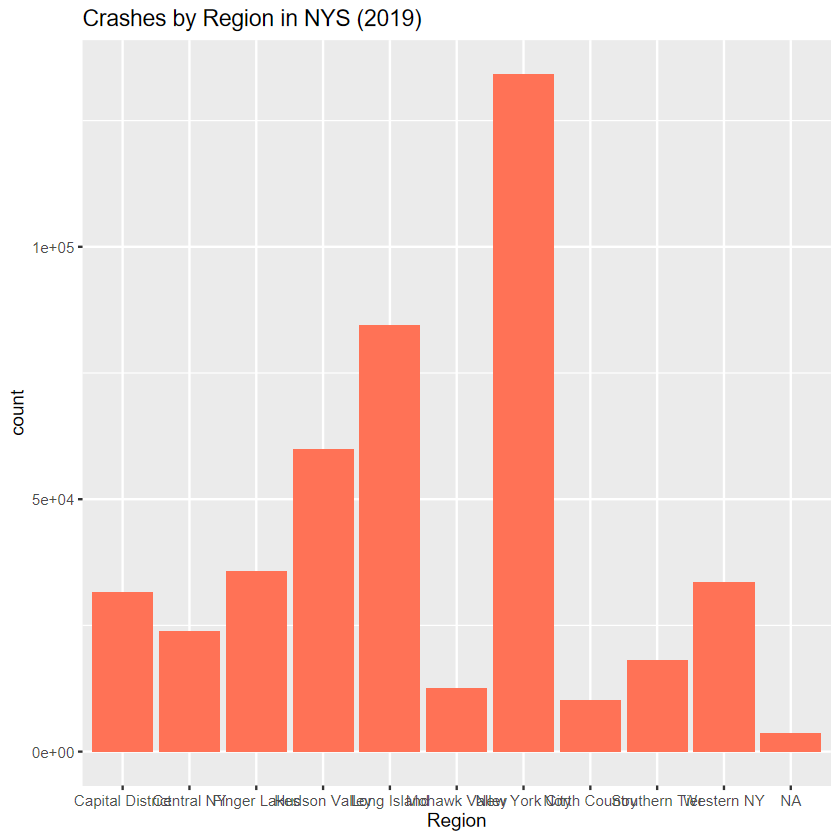

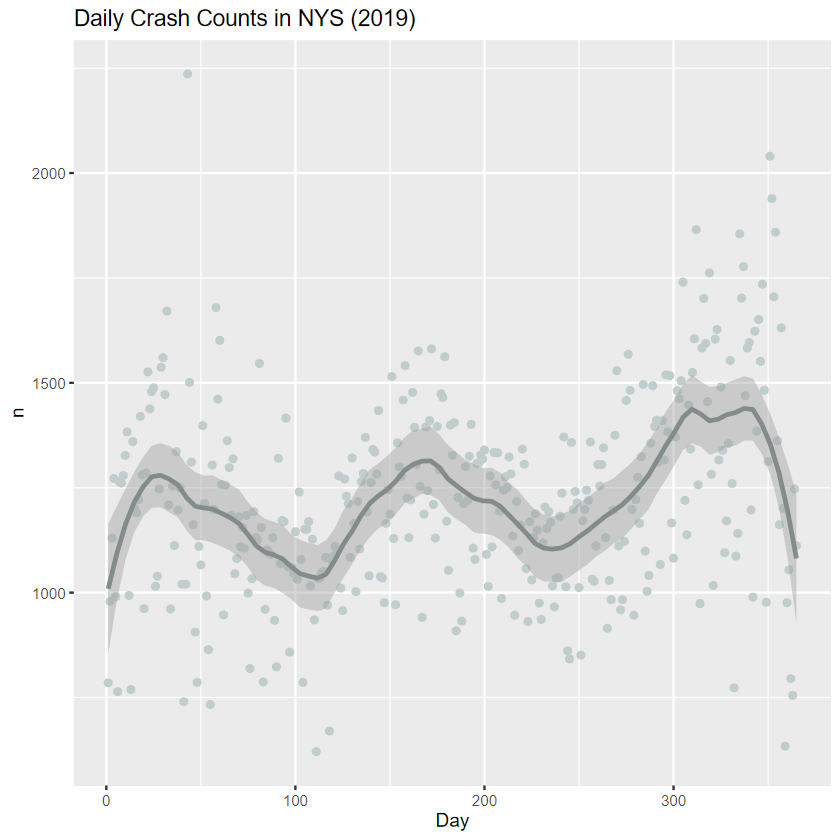

In [7]:
# ========== 2. Load and Prepare Crash Data ==========
Crashes <- read.csv("C:/Users/26759/Documents/Materials/MATH 540/NY Traffic Tickets/Motor_Vehicle_Crashes_-_Case_Information__Three_Year_Window.csv", header = TRUE)

Crashes1 <- Crashes %>%
  filter(Year == 2019, County.Name != "UNKNOWN") %>%
  mutate(Region = map_region(County.Name))

# Basic crash count plots

# Crashes by day of week
Crashes1 %>%
  ggplot(aes(x = Day.of.Week)) +
  geom_bar(fill = "maroon3") +
  labs(title = "Crashes by Day of Week (2019)")

# Crashes by region
ggplot(Crashes1, aes(x = Region)) +
  geom_bar(fill = "coral1") +
  labs(title = "Crashes by Region in NYS (2019)")

# Daily crash counts
daily_crashes <- Crashes1 %>% count(Date)
daily_crashes$Day <- 1:nrow(daily_crashes)

# Scatter plot of daily crash counts
ggplot(daily_crashes, aes(x = Day, y = n)) +
  geom_point(color = "azure3") +
  stat_smooth(span = 0.2, color = "azure4") +
  labs(title = "Daily Crash Counts in NYS (2019)")

#### Key Findings

Our analysis reveals several notable trends in the 2019 NYS crash data:

- **Temporal patterns**: Crash counts peaked on **Fridays**, with lower numbers on **Sundays** and **Mondays**, suggesting a strong link between weekday commuting and crash likelihood.
- **Regional variation**: **New York City**, **Long Island**, and **Hudson Valley** accounted for the highest crash volumes, mirroring their population density and traffic levels. Rural regions such as **North Country** and **Mohawk Valley** experienced far fewer crashes.
- **Seasonal dynamics**: A smoothed trend of daily crash counts highlighted clear **summer and winter peaks**, with a noticeable **mid-February spike** likely tied to a severe snowstorm. These patterns underscore the impact of **seasonality and weather conditions** on traffic safety.

Together, these findings point to how both human behavior (workweek schedules, regional population density) and environmental conditions (seasons, weather events) shape crash risks across New York State.


## 3. Seasonal Crash Patterns

### Seasonal Variation in Crash Frequency

To explore whether crash rates differ significantly across the four seasons, we assigned each date in 2019 to a season (Spring, Summer, Fall, or Winter) based on its day-of-year index. We then aggregated total crash counts by season and visualized them with a bar chart.

Additionally, we fit a linear model with season as a categorical predictor to assess whether the differences observed in the plot are statistically significant.



Call:
lm(formula = n ~ Season, data = daily_crashes)

Residuals:
    Min      1Q  Median      3Q     Max 
-688.89 -132.89  -11.23  135.12 1115.12 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1216.61      23.56  51.629  < 2e-16 ***
SeasonSpring   -95.73      33.42  -2.865  0.00442 ** 
SeasonSummer    24.63      33.15   0.743  0.45802    
SeasonWinter   106.28      33.70   3.153  0.00175 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 226 on 361 degrees of freedom
Multiple R-squared:  0.09166,	Adjusted R-squared:  0.08411 
F-statistic: 12.14 on 3 and 361 DF,  p-value: 1.374e-07


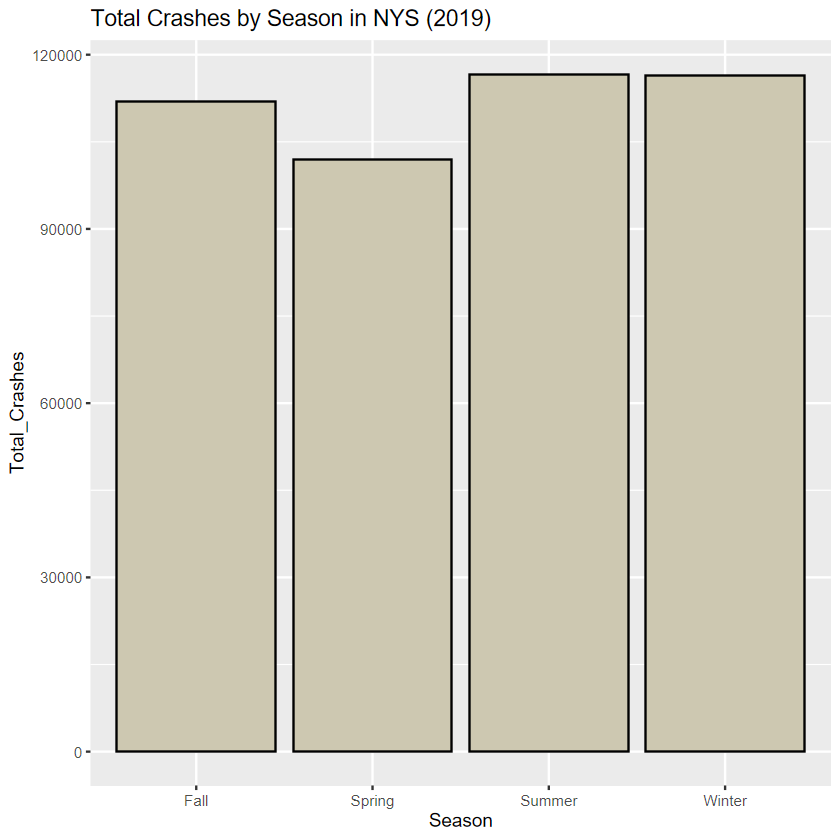

In [9]:
# ========== 3. Seasonal Analysis ==========

daily_crashes$Day <- 1:nrow(daily_crashes)  # 恢复 Day 变量

daily_crashes$Season <- case_when(
  daily_crashes$Day >= 35 & daily_crashes$Day < 126 ~ "Spring",
  daily_crashes$Day >= 126 & daily_crashes$Day < 220 ~ "Summer",
  daily_crashes$Day >= 220 & daily_crashes$Day < 312 ~ "Fall",
  TRUE ~ "Winter"
)

# Linear model: Crash counts ~ Season
lm_season <- lm(n ~ Season, data = daily_crashes)
summary(lm_season)

# Barplot of total crashes by season
season_totals <- daily_crashes %>%
  group_by(Season) %>%
  summarise(Total_Crashes = sum(n))

ggplot(season_totals, aes(x = Season, y = Total_Crashes)) +
  geom_bar(stat = "identity", fill = "cornsilk3", color = "black") +
  labs(title = "Total Crashes by Season in NYS (2019)")


#### Observations and Statistical Findings

The bar chart shows that crash counts in **Winter** and **Summer** are the highest, while **Spring** has the lowest number of total crashes. This suggests a possible U-shaped seasonal pattern, with increased crashes during colder and hotter months.

The linear model confirms that the **seasonal effect is statistically significant** (p < 0.001). Specifically:
- **Winter** has significantly more crashes than **Fall** (baseline), with an estimated increase of ~106 crashes/day (p = 0.00175)
- **Spring** has significantly fewer crashes than Fall, with an estimated decrease of ~96 crashes/day (p = 0.0044)
- The difference between **Summer** and Fall is not statistically significant

These results indicate that winter weather and potentially higher traffic volumes in summer might both contribute to elevated crash risks, while spring remains comparatively safer.


## 4. Smoothing Daily Crash Trends with GAM

To better capture the non-linear and potentially complex temporal patterns in crash frequency over the year, we applied a Generalized Additive Model (GAM). Unlike linear models with fixed seasonal terms, GAM allows for flexible smoothing over time using spline functions.

Here, we modeled daily crash counts as a smooth function of the day index (`1–365`), enabling us to visualize seasonal fluctuation without imposing rigid seasonal cutoffs.


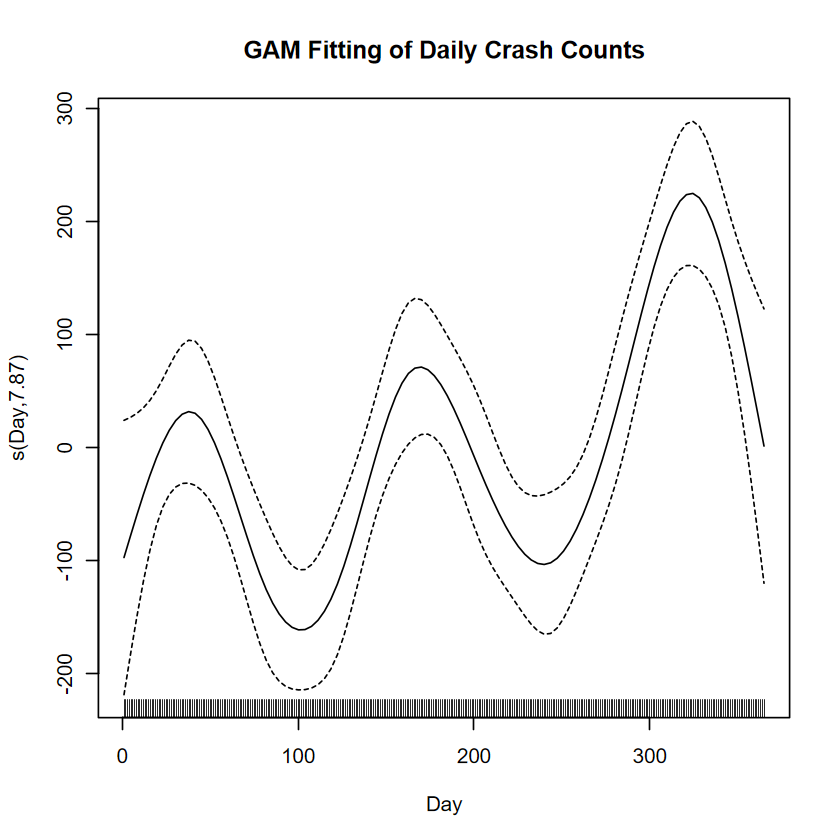

In [10]:
# ========== 4. Bonus: GAM fitting for crash trends ==========

gam_model <- gam(n ~ s(Day, bs = "cs"), data = daily_crashes)
plot(gam_model, main = "GAM Fitting of Daily Crash Counts")

## 5. Causal Analysis
### Weather-Induced Outliers: February Snowstorm Case

While analyzing daily crash frequency in 2019, a sharp spike appeared around **February 12–13**. To investigate this anomaly, we referred to NOAA's local weather reports, which confirmed that a significant winter storm struck **eastern New York State**, particularly the **Southern Adirondacks and Capital Region**, during this time period.

This storm caused widespread hazardous driving conditions including icy roads and poor visibility, likely leading to the spike in crash counts observed in our data. Interestingly, the **Southern Tier region (e.g., Binghamton)** did not experience significant snowfall on the same day, aligning with the regional variability in crash patterns.

> 📚 Source: [NOAA Case Study on Feb 12–13, 2019 Wintry Mix](https://www.weather.gov/media/aly/LocalResearch/Online%20LocalResearch/Case_Studies/Feb12-13_2019_wintrymix.pdf)

This highlights how **localized extreme weather** events can meaningfully impact traffic safety and introduces a compelling avenue for future work incorporating meteorological data directly into crash prediction models.


#### Interpretation

The GAM smooth reveals multiple distinct peaks and troughs in daily crash frequency throughout 2019. Three key local maxima occur around:

- **Late winter / early spring (~Day 40)** — potentially linked to icy road conditions
- **Mid-summer (~Day 190)** — likely reflecting vacation-related travel and tourism
- **Early winter (~Day 330)** — possibly influenced by holiday traffic and early snowfall

Compared to the linear seasonal model, the GAM approach provides a more nuanced view of crash dynamics, identifying **multi-peak structures** that align with plausible external influences such as weather, holidays, and travel behavior. The shaded confidence band confirms the robustness of these seasonal patterns.


## 6. Summary & Conclusion

Our analysis of NYS motor vehicle crashes in 2019 reveals several consistent and interpretable trends:

1. **Weekday Patterns**: Crash volumes peak on **Fridays**, with **Sundays** and **Mondays** being relatively safer days. This aligns with typical weekday commuting patterns and increased end-of-week mobility.

2. **Regional Disparities**: **New York City** and **Long Island** dominate in both vehicle registrations and crash counts, reflecting their dense urban environments. In contrast, rural areas like the **North Country** and **Mohawk Valley** report substantially fewer crashes.

3. **Seasonal Effects**:
   - **Winter** and **Summer** are the riskiest seasons, while **Spring** shows the fewest crashes.
   - A linear model confirms statistically significant increases in crash counts during **Winter**, and decreases in **Spring**, relative to **Fall**.

4. **Daily Trends and Non-Linear Patterns**:
   - A **GAM smoothing** of daily crash counts reveals a **multi-modal structure**, with notable peaks in early February (potentially weather-related), mid-summer (vacation traffic), and December (holiday season).
   - This suggests that crash risk is not only seasonal but also influenced by shorter-term calendar events.

Together, these insights illustrate how **crash risks are shaped by the intersection of geography, seasonality, and human behavior**. Densely populated regions and periods of high mobility (e.g., holidays, summer breaks) correspond to elevated crash frequencies.

This exploratory analysis provides a foundation for more targeted research or predictive modeling—for example, forecasting high-risk periods for traffic enforcement or public safety messaging.
